(scheme:crank-nicholson)=
# The Crank-Nicholson Scheme

Until now, all schemes have time step limitations in the form of the CFL condition $c\Delta t/\Delta x \leq 1$. One way to overcome that limitation is to use *implicit* schemes, where the spatial derivatives are evaluated at $t^{n+1}$. One such scheme is the Crank-Nicholson scheme:

$$
  \frac{u_m^{n+1}-u_m^n}{\Delta t} = -\frac{c}{2}\left(\frac{u_{m+1}^{n+1}-u_{m-1}^{n+1}}{2\Delta x} + \frac{u_{m+1}^{n}-u_{m-1}^{n}}{2\Delta x}\right)
$$ (eq:schemeCrankNicholson)

The scheme uses a forward approximation to the time derivative at $t^n$ and the average of the centred approximations of the space derivative at $t^n$ and $t^{n+1}$. 

Another way of looking at {eq}`eq:schemeCrankNicholson` is that the LHS is a centred approximation of the time derivative at $t^{n+1/2}$ and the averaging of the spatial derivatives provides an estimate of the spatial derivative at $t^{n+1/2}$.

The use of the terms at $t^{n+1}$ poses a complication because these are not known at time $t^n$. Therefore, the scheme is not an explicit time marching scheme as we have seen so far, but one where the solution is implicit in the scheme itself, hence the designation of *implicit* scheme. To obtain the unknown values at $t^{n+1}$, a linear system of equations must be solved. 

We can expand {eq}`eq:schemeCrankNicholson` to obtain 

$$
  -\frac{\sigma}{4}u_{m-1}^{n+1}  + u_m^{n+1} + \frac{\sigma}{4}u_{m+1}^{n+1} =
    \frac{\sigma}{4}u_{m-1}^{n}  + u_m^{n} - \frac{\sigma}{4}u_{m+1}^{n},\quad \sigma = c\frac{\Delta t}{\Delta x}   
$$

that is a linear system of equations 

$$
  A\mathbf{u}^{n+1}=B\mathbf{u}^{n}.
$$ (eq:schemeAB)

The matrices $A$ and $B$, are in the case of Dirichlet boundary conditions $u(0,t)=u(L,t)=0$

$$
A = 
\begin{pmatrix}
  1                        & \frac{\sigma}{4}   & 0                             &         0                & \cdots & 0\\
  -\frac{\sigma}{4} & 1                         & \frac{\sigma}{4}       &         0                & \cdots & 0\\
                          0 & -\frac{\sigma}{4} & 1                              & \frac{\sigma}{4} & \cdots & 0\\
            \vdots       &          \vdots        &   \vdots                     & \ddots               & \vdots  & \vdots\\
            0               &              \cdots           &            0             & -\frac{\sigma}{4} & 1                         & \frac{\sigma}{4} \\
         0               &              \cdots           &        0                 & 0                 &-\frac{\sigma}{4} & 1                         \\
\end{pmatrix}
$$

$$
B = 
\begin{pmatrix}
  1                        & -\frac{\sigma}{4}   & 0                             &         0                & \cdots & 0\\
  \frac{\sigma}{4} & 1                         & -\frac{\sigma}{4}       &         0                & \cdots & 0\\
                          0 & \frac{\sigma}{4} & 1                              & -\frac{\sigma}{4} & \cdots & 0\\
            \vdots       &          \vdots        &   \vdots                     & \ddots               & \vdots  & \vdots\\
            0               &              \cdots           &            0             & \frac{\sigma}{4} & 1                         & -\frac{\sigma}{4} \\
         0               &              \cdots           &        0                 & 0                 &\frac{\sigma}{4} & 1                         \\
\end{pmatrix}
$$

In the case $A$ and $B$ are tridiagonal, as above, the solution of the linear system {eq}`eq:schemeAB` is expedite. In other cases, iterative methods must be used.

## Consistency, stability and convergence

The scheme has a truncation error $O(\Delta t^2,\Delta x^2)$, since the spatial derivatives are approximated by a centred formula and the time derivative also, at $t^{n+1/2}$.
The stability of the scheme can be determined by the usual method of assuming a solution of the form $B^n e^{i\lambda m \Delta x}$ and noting that

$$
    u_{m+1}^{n}-u_{m-1}^{n} = (2i\sin\lambda \Delta x)u_{m}^{n}
$$

we arrive at the following amplification factor:

$$
   G = \frac{u_{m}^{n+1}}{u_{m}^{n}} = \frac{1-(\sigma/2)i\sin\lambda \Delta x}{1+(\sigma/2)i\sin\lambda \Delta x},
$$(eq:ampFactorCN)

whose norm $|G|$ is

$$
 |G| = \left| \frac{1-(\sigma/2)i\sin\lambda \Delta x}{1+(\sigma/2)i\sin\lambda \Delta x}\right| = 
    \frac{ \left|1-(\sigma/2)i\sin\lambda \Delta x\right|}{ \left|1+(\sigma/2)i\sin\lambda \Delta x\right|} = 1.
$$

The scheme is, therefore, *unconditionally stable* and doesn't suffer from CFL limitations, unlike the previous explicit schemes.

## Application: propagation of top hat function

To test the scheme, we are going to apply it to the propagation of the top hat signal.

In [1]:
def topHat(x):
   f0=np.zeros(x.shape)
   f0[(x>0.45) & (x<0.55)]=1

   return f0

The Crank-Nicholson scheme is implemented in the following Python function:

In [2]:
def crankNicholson(u0,c,dt,dx,N,M):

    # Initial condition
    u=u0.copy()

    # CFL number
    C = c*dt/dx
    
    # System of equations
    
    # Au^(n+1) = B*u^n
    
    # Fill matrices
    alpha=0.5

    r1=(1-alpha)*C/2
    r2=alpha*C/2
    
    ones = np.ones((M-2,))
    H = spdiags( [-r2*ones, ones, r2*ones], (-1,0,1), M-2, M-2 )
    B = spdiags( [r1*ones, ones, -r1*ones], (-1,0,1), M-2, M-2 )
  
    for l in range(1, N):
        
        V=B*u[1:-1]
        u[1:-1] = spsolve(H.tocsc(), V)
        
    return u

In the next code snippet, we set the discretization parameters and integrate the initial condition with the Crank-Nicholson scheme:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags

N     = 30       # Number of time steps
M     = 100      # Number of grid points
c     = 0.75     # Propagation speed

dt = 0.01
dx = 1/M

print("Number of time steps = {:d}".format(N))
print("Number of grid points = {:d}".format(M))
print("Time step = {:f}".format(dt))
print("Grid size = {:f}".format(dx))
print("CFL number = {:f}".format(c*dt/dx))

# Grid points
X=np.linspace(0,1,M)

# Integrate the initial condition N time steps
U=crankNicholson(topHat(X),c,dt,dx,N,M)

Number of time steps = 30
Number of grid points = 100
Time step = 0.010000
Grid size = 0.010000
CFL number = 0.750000


The solution at the end of the integration is shown below:

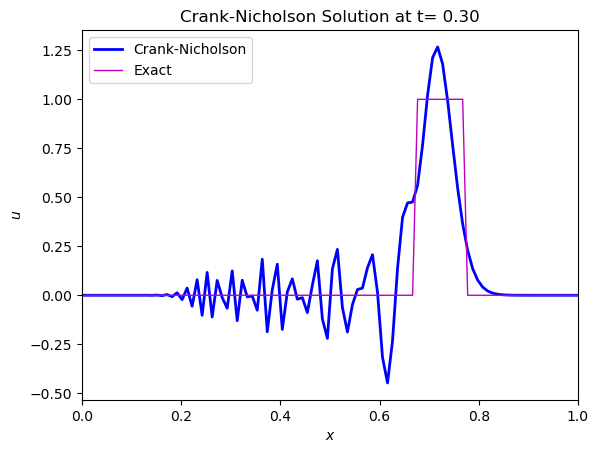

In [4]:
# Shift the exact solution a distance equivalent to c*N*dt
newX = np.mod(X-c*N*dt,1)

fig, ax0 = plt.subplots()

ax0.plot(X, U, lw = 2, color = "b",  label='Crank-Nicholson')
ax0.plot(X, topHat(newX), lw = 1, color = "m",  label='Exact')

ax0.set_title("Crank-Nicholson Solution at t={:5.2f}".format(N*dt))
ax0.set_xlabel('$x$')
ax0.set_xlim([0, 1])
ax0.set_ylabel('$u$')
ax0.legend()

plt.show()

The unconditional stability of the implicit Crank-Nicholson scheme is its great advantage, but it's use in the advection equation has unwanted consequences in the form of dispersion and errors in the phase speed. The comparison with the Leapfrog scheme shows that the scheme, although unconditionally stable still suffers from dispersive behaviour.



From {eq}`eq:ampFactorCN`, we can write

$$
   \mathbf{u}^n = G\mathbf{u}^{n-1}= \dotso = G^{(n)} \mathbf{u}^0
$$

or

$$
   u_m^n = BG^{(n)} e^{i\lambda m\Delta x}
$$

Substituting {eq}`eq:ampFactorCN`, we obtain the following expression for the phase speed $c_F$ of the numerical solution

$$
  c_F = \frac{2\theta}{\lambda \Delta t}, \quad \theta = \tan^{-1}\left( \frac{\sigma}{2} \sin \lambda \Delta x \right)
$$

For shortwaves in the numerical solution, e.g. the $2\Delta x$ wavelength, we have $\lambda = \pi/\Delta x$ and $\theta = \tan^{-1} (\sigma/2 \sin \pi)=0$, which means the shortwave is stationary. For large wavelength, we have $\lambda \Delta x \ll 1$ and

$$
  \theta = \tan^{-1} {\frac{\sigma}{2} \sin \lambda \Delta x} = \tan^{-1} (\frac{c\lambda \Delta t}{2})
$$

For small $\Delta t$, we'll have $\theta = \frac{c\lambda \Delta t}{2} $ and $c_F = c$. But for large $\Delta t$, it will be $\theta = \pi/2$ and $c_F = \pi/\Delta t \lambda$, which is independent of $c$. 

Therefore, either for shortwave components or long wavelengths we will have errors in the phase speed of the numerical solution that make the use of the Crank-Nicholson scheme dubious for the linear advection problem.